# Emerging Topics final code

This code was created from Martha and Sean's emerging topic code.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns

### Data Ingestion

In [2]:
# full corpus
#df = pd.read_pickle("../../data/final/final_dataset_7-20.pkl")

# pandemic corpus
df = pd.read_pickle("../../data/final/dashboard_data/pandemic_corpus.pkl")
df.reset_index(inplace=True)

# coronavirus corpus
#df = pd.read_pickle("../../data/final/dashboard_data/corona_corpus.pkl")
#df.reset_index(inplace=True)

In [3]:
df.head()

,level_0,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,...,working_abstract,Start_Char,nchar,LAST_CHAR,lemma_abstract,clean_lemmas,stopwds_removed,n_grams_added,final_tokens,final_frqwds_removed
0,767,767,1001101,1101109,Topic Area: InfluenzaArea of Emphasis: Develop...,2017,Adaptive Immune System; Address; Adjuvant; aer...,"APPLICATION OF AN IMMUNE-MODULATING, ANTI-INFL...",DOD,CDMRP,...,Topic Area: InfluenzaArea of Emphasis: Develop...,T,4219,y,"[topic, area, InfluenzaArea, emphasis, develop...","[topic, area, influenzaarea, emphasis, develop...","[topic, area, influenzaarea, emphasis, develop...","[topic, area, influenzaarea, emphasis, develop...","[topic, area, influenzaarea, emphasis, develop...","[topic, influenzaarea, emphasis, evaluation, i..."
1,1670,1670,935775,1145806,﻿DESCRIPTION (provided by applicant): Respirat...,2019,Activities of Daily Living; airway epithelium;...,EXOGENOUS PGI2 PROTECTION AGAINST RSV-INDUCED ...,HHS,NIH,...,Respiratory syncytial virus (RSV) is the leadi...,R,3068,e,"[respiratory, syncytial, virus, RSV, lead, cau...","[respiratory, syncytial, virus, rsv, lead, cau...","[respiratory, syncytial, virus, rsv, lead, cau...","[respiratory_syncytial_virus, rsv, lead, cause...","[respiratory_syncytial_virus, rsv, lead, cause...","[respiratory_syncytial_virus, rsv, infant, hos..."
2,1671,1671,781656,842147,﻿ DESCRIPTION (provided by applicant): Respi...,2016,Activities of Daily Living; airway epithelium;...,EXOGENOUS PGI2 PROTECTION AGAINST RSV-INDUCED ...,HHS,NIH,...,Respiratory syncytial virus (RSV) is the leadi...,R,3065,e,"[respiratory, syncytial, virus, RSV, lead, cau...","[respiratory, syncytial, virus, rsv, lead, cau...","[respiratory, syncytial, virus, rsv, lead, cau...","[respiratory_syncytial_virus, rsv, lead, cause...","[respiratory_syncytial_virus, rsv, lead, cause...","[respiratory_syncytial_virus, rsv, infant, hos..."
3,2477,2477,21794,154102,DESCRIPTION (provided by applicant): Hepatiti...,2008,Acids; Acute; Adult; Anabolism; Antiviral Agen...,REGULATION OF HEPATITIS B VIRUS TRANSCRIPTION,HHS,NIH,...,Hepatitis B virus (HBV) infection is a worldwi...,H,1985,n,"[hepatitis, b, virus, hbv, infection, worldwid...","[hepatitis, b, virus, hbv, infection, worldwid...","[hepatitis, b, virus, hbv, infection, worldwid...","[hepatitis, b, virus, hbv, infection, worldwid...","[hepatitis, virus, hbv, infection, worldwide, ...","[hepatitis, virus, hbv, infection, worldwide, ..."
4,2576,2576,21967,154173,DESCRIPTION (provided by applicant): The World...,2008,Acute Hepatitis; Address; Animal Model; Antivi...,ANALYZING HEPATITIS B VIRUS PATHOGENESIS,HHS,NIH,...,The World Health Organization estimates that 3...,T,2744,d,"[World, Health, Organization, estimate, 350, m...","[world, health, organization, estimate, 350, m...","[world, health, organization, estimate, 350, m...","[world, health, organization, estimate, 350, m...","[world, health, organization, estimate, millio...","[world, health, organization, estimate, millio..."


In [4]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []
docs = df["final_frqwds_removed"]

for abstract in docs:
    text.append(" ".join(abstract))

### Functions needed for all models

In [5]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [6]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(model, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF
- Optimal Model: full dataset, 75 topics, random_state = 14
- Pandemic Model: pandemic dataset, 30, random_state = 1
- Coronavirus Model: coronavirus dataset, 30, random_state = 1

In [7]:
# use for full dataset
#tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
#tf_idf = tfidf_vectorizer.fit_transform(text)

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False)
tf_idf = tfidf_vectorizer.fit_transform(text)


In [8]:
# create model

num_topics = 30 

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

  Model time: 2.026527166366577


In [9]:
print_topics(nmf_model, tfidf_vectorizer, 10)


Topic 0:
('virus', 2.7160698034368003)
('influenza', 1.5197190758119827)
('1918', 0.9840805625081587)
('human', 0.9023270495374102)
('pandemic', 0.7551108659933577)
('iav', 0.6852008791905722)
('2009', 0.637833799113394)
('host', 0.5320422125411107)
('virulence', 0.515148638855147)
('swine', 0.509826807963378)

Topic 1:
('rsv', 2.1919362818177768)
('infant', 0.2411861420043897)
('airway', 0.22440584759380175)
('mucus', 0.1624570360941281)
('respiratory_syncytial_virus', 0.15168900765486684)
('pgi2', 0.14721751957952042)
('il', 0.13204712551846745)
('child', 0.11105745968339743)
('infection', 0.10499616747044352)
('protein', 0.08870859087942354)

Topic 2:
('hbv', 2.1704281307164726)
('replication', 0.2562070664797717)
('liver', 0.2307373608227232)
('hepatitis', 0.22127864814996334)
('chronic', 0.20796707418707758)
('hepatocyte', 0.19890780950245507)
('dna', 0.17933661317777388)
('hbx', 0.14372971387208064)
('cell', 0.12987809086750468)
('rna', 0.12149983200299061)

Topic 3:
('denv', 2.

### Emerging Topics

In [10]:
# Extract Year from PROJECT_START_DATE

#On our graphs, we want to be able to show year. Therefore, this getYear function gets the year from different date formats from Project Start Year/End Year

#START

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)

In [11]:
df["START_YEAR"].value_counts()

2009    117
2010    105
2012     90
2011     87
2018     84
2008     81
2019     77
2014     76
2015     74
2017     68
2016     59
2013     55
2007     51
2006     22
2005     16
2004     14
2003     12
1999      8
2001      5
1996      4
1983      4
1990      3
1993      3
1994      3
1992      3
1988      3
1989      2
1977      2
1997      2
2002      2
1987      2
1991      1
1978      1
1981      1
Name: START_YEAR, dtype: int64

In [12]:
df.dtypes

level_0                         int64
index                           int64
original index                  int64
PROJECT_ID                     object
ABSTRACT                       object
FY                             object
PROJECT_TERMS                  object
PROJECT_TITLE                  object
DEPARTMENT                     object
AGENCY                         object
IC_CENTER                      object
PROJECT_NUMBER                 object
PROJECT_START_DATE             object
PROJECT_END_DATE               object
CONTACT_PI_PROJECT_LEADER      object
OTHER_PIS                      object
CONGRESSIONAL_DISTRICT         object
DUNS_NUMBER                    object
ORGANIZATION_NAME              object
ORGANIZATION_CITY              object
ORGANIZATION_STATE             object
ORGANIZATION_ZIP               object
ORGANIZATION_COUNTRY           object
BUDGET_START_DATE              object
BUDGET_END_DATE                object
CFDA_CODE                      object
FY.y        

In [13]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]


In [14]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [15]:
topic_frame.head()

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
0,1977,0.010530,0.021894,0.000000,0.0,0.019813,0.0,0.000000,0.000000,0.004936,...,0.000000,0.0,0.000000,0.000000,0.000000,0.197237,0.000000,0.038247,0.000000,0.000000
1,1978,0.000000,0.000000,0.316913,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.032872,0.0,0.000000,0.005665,0.000000,0.001067,0.000000,0.000000,0.000000,0.004604
2,1981,0.011108,0.000000,0.007769,0.0,0.003911,0.0,0.000000,0.015236,0.004058,...,0.039266,0.0,0.093665,0.000000,0.003833,0.014312,0.000000,0.000000,0.007816,0.046909
3,1983,0.040033,0.000000,0.000000,0.0,0.008432,0.0,0.006975,0.000917,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.137674,0.000000,0.127365,0.000000,0.000575
4,1987,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.009195,...,0.000000,0.0,0.001091,0.003638,0.000000,0.183833,0.000625,0.010899,0.000000,0.003010


In [16]:
# filter topic_frame for years 2010 - 2019

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < 2020] 

In [17]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
24,2010,0.012203,0.014236,0.022599,0.006875,0.027831,0.000626,0.022336,0.009348,0.007776,...,0.009813,0.004814,0.008135,0.004373,0.015268,0.014224,0.005934,0.027910,0.009682,0.008749
25,2011,0.011010,0.033435,0.015480,0.004880,0.023089,0.000461,0.027135,0.011577,0.010658,...,0.009865,0.005879,0.007665,0.003895,0.012134,0.008602,0.002607,0.036591,0.012444,0.001784
26,2012,0.013156,0.015894,0.009497,0.009304,0.023630,0.001682,0.025067,0.015901,0.003680,...,0.008769,0.005534,0.012608,0.003333,0.020992,0.009576,0.007998,0.022925,0.011041,0.005787
27,2013,0.011561,0.024421,0.028021,0.029127,0.020541,0.002212,0.010372,0.019705,0.004859,...,0.011091,0.008062,0.012028,0.002393,0.011974,0.013249,0.012440,0.013641,0.014458,0.002638
28,2014,0.011713,0.025335,0.018488,0.022034,0.013566,0.000337,0.017737,0.017424,0.033447,...,0.008878,0.001912,0.008933,0.004714,0.008295,0.014097,0.009025,0.014475,0.002435,0.007646
29,2015,0.008841,0.050994,0.021295,0.017874,0.014254,0.000383,0.019981,0.018957,0.005451,...,0.010600,0.002368,0.013167,0.007654,0.008964,0.013818,0.013291,0.022619,0.005882,0.011435
30,2016,0.010954,0.024946,0.022041,0.024449,0.018186,0.012959,0.017239,0.013571,0.005870,...,0.010419,0.002035,0.011098,0.011624,0.007501,0.012212,0.013712,0.021511,0.002297,0.005745
31,2017,0.009142,0.030744,0.017774,0.028105,0.013450,0.050480,0.018281,0.012764,0.003268,...,0.012663,0.002437,0.011530,0.010041,0.008680,0.016754,0.001885,0.014771,0.002978,0.012723
32,2018,0.006478,0.026186,0.026308,0.020609,0.011202,0.049654,0.012335,0.017483,0.004572,...,0.007800,0.001632,0.010751,0.010992,0.015382,0.017225,0.002188,0.011719,0.001692,0.013065
33,2019,0.005034,0.041672,0.023457,0.024413,0.008446,0.042308,0.017308,0.010176,0.003565,...,0.009093,0.001375,0.011239,0.010543,0.011171,0.016371,0.002285,0.010920,0.002905,0.007060


In [18]:
# perform regressions, track slopes

topic_slopes = []

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    
    topic_slopes.append(linear_fit.coef_[0][0])

In [19]:
topic_slopes

[-0.0007333877071754537,
 0.0018040328831855957,
 0.0006652807478100185,
 0.002083392568331461,
 -0.0019087540488481778,
 0.006034915593872668,
 -0.000969271062751525,
 9.844125245000055e-05,
 -0.0006516540018516153,
 0.0003096502765931134,
 -0.0007362954926482021,
 -0.0008586686532731894,
 -0.0007076877911044316,
 -0.000718662835553196,
 0.0003068206386972448,
 0.0011525546424196206,
 -0.0010063000075828386,
 -0.000996037426793539,
 0.000877156136572735,
 -0.001829008033436158,
 -1.0647497964704385e-05,
 -0.000568400009807578,
 0.0002763060104637601,
 0.001026567138210735,
 -0.0005360135449038473,
 0.0006798608920710908,
 -0.00035306865411332617,
 -0.002036517803449092,
 -0.0012703596450920982,
 0.0006761273963069891]

In [20]:
hot_cold = []

for slope in topic_slopes:
    if slope > 0:
        hot_cold.append("hot")
    else:
        hot_cold.append("cold")

In [21]:
hot_cold

['cold',
 'hot',
 'hot',
 'hot',
 'cold',
 'hot',
 'cold',
 'hot',
 'cold',
 'hot',
 'cold',
 'cold',
 'cold',
 'cold',
 'hot',
 'hot',
 'cold',
 'cold',
 'hot',
 'cold',
 'cold',
 'cold',
 'hot',
 'hot',
 'cold',
 'hot',
 'cold',
 'cold',
 'cold',
 'hot']

In [22]:
topic_words = str_topics(nmf_model, tfidf_vectorizer, top_n=10)

In [23]:
topic_words

['virus, influenza, 1918, human, pandemic, iav, 2009, host, virulence, swine',
 'rsv, infant, airway, mucus, respiratory_syncytial_virus, pgi2, il, child, infection, protein',
 'hbv, replication, liver, hepatitis, chronic, hepatocyte, dna, hbx, cell, rna',
 'denv, immune, infection, autophagy, immunity, denv_serotype, vaccine, dengue, cell, relationship',
 'hiv, aids, infect, cell, infection, individual, art, transmission, incidence, viral',
 'zikv, zika_virus_zikv, microcephaly, infection, flavivirus, fetal, brain, pregnancy, congenital, maternal',
 'vaccine, virus, adjuvant, vlp, dose, protective, strain, antigen, efficacy, live',
 'cd8_t, cell, memory, infection, dendritic, brucella, cd4, chronic, mouse, functional',
 'influenza, ecologic, cross_protection, environmental, immune, pathogenicity, evolution, influence, emergence, correlate',
 'dengue, severe, adult, illness, infection, patient, clinical, serotype, child, management',
 'animal, bird, close, contact, surveillance, influe

In [24]:
# package up data for data table in RShiny dashboard

reg_topics = pd.DataFrame()
reg_topics["Slope"] = topic_slopes
reg_topics["Hot or Cold"] = hot_cold
reg_topics["Topic Words"] = topic_words 


In [25]:
reg_topics

,Slope,Hot or Cold,Topic Words
0,-0.000733,cold,"virus, influenza, 1918, human, pandemic, iav, ..."
1,0.001804,hot,"rsv, infant, airway, mucus, respiratory_syncyt..."
2,0.000665,hot,"hbv, replication, liver, hepatitis, chronic, h..."
3,0.002083,hot,"denv, immune, infection, autophagy, immunity, ..."
4,-0.001909,cold,"hiv, aids, infect, cell, infection, individual..."
5,0.006035,hot,"zikv, zika_virus_zikv, microcephaly, infection..."
6,-0.000969,cold,"vaccine, virus, adjuvant, vlp, dose, protectiv..."
7,0.000098,hot,"cd8_t, cell, memory, infection, dendritic, bru..."
8,-0.000652,cold,"influenza, ecologic, cross_protection, environ..."
9,0.000310,hot,"dengue, severe, adult, illness, infection, pat..."


In [26]:
#reg_topics.to_csv("./reg_topics.csv", index=False)
#reg_topics.to_csv("./pan_topics.csv", index=False)
#reg_topics.to_csv("./cor_topics.csv", index=False)

## Create plots - top 5 hot and cold topics, static plots

In [27]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
24,2010,0.012203,0.014236,0.022599,0.006875,0.027831,0.000626,0.022336,0.009348,0.007776,...,0.009813,0.004814,0.008135,0.004373,0.015268,0.014224,0.005934,0.027910,0.009682,0.008749
25,2011,0.011010,0.033435,0.015480,0.004880,0.023089,0.000461,0.027135,0.011577,0.010658,...,0.009865,0.005879,0.007665,0.003895,0.012134,0.008602,0.002607,0.036591,0.012444,0.001784
26,2012,0.013156,0.015894,0.009497,0.009304,0.023630,0.001682,0.025067,0.015901,0.003680,...,0.008769,0.005534,0.012608,0.003333,0.020992,0.009576,0.007998,0.022925,0.011041,0.005787
27,2013,0.011561,0.024421,0.028021,0.029127,0.020541,0.002212,0.010372,0.019705,0.004859,...,0.011091,0.008062,0.012028,0.002393,0.011974,0.013249,0.012440,0.013641,0.014458,0.002638
28,2014,0.011713,0.025335,0.018488,0.022034,0.013566,0.000337,0.017737,0.017424,0.033447,...,0.008878,0.001912,0.008933,0.004714,0.008295,0.014097,0.009025,0.014475,0.002435,0.007646
29,2015,0.008841,0.050994,0.021295,0.017874,0.014254,0.000383,0.019981,0.018957,0.005451,...,0.010600,0.002368,0.013167,0.007654,0.008964,0.013818,0.013291,0.022619,0.005882,0.011435
30,2016,0.010954,0.024946,0.022041,0.024449,0.018186,0.012959,0.017239,0.013571,0.005870,...,0.010419,0.002035,0.011098,0.011624,0.007501,0.012212,0.013712,0.021511,0.002297,0.005745
31,2017,0.009142,0.030744,0.017774,0.028105,0.013450,0.050480,0.018281,0.012764,0.003268,...,0.012663,0.002437,0.011530,0.010041,0.008680,0.016754,0.001885,0.014771,0.002978,0.012723
32,2018,0.006478,0.026186,0.026308,0.020609,0.011202,0.049654,0.012335,0.017483,0.004572,...,0.007800,0.001632,0.010751,0.010992,0.015382,0.017225,0.002188,0.011719,0.001692,0.013065
33,2019,0.005034,0.041672,0.023457,0.024413,0.008446,0.042308,0.017308,0.010176,0.003565,...,0.009093,0.001375,0.011239,0.010543,0.011171,0.016371,0.002285,0.010920,0.002905,0.007060


In [28]:
# Sean's plots - legend

leg = str_topics(nmf_model, tfidf_vectorizer, top_n=5)

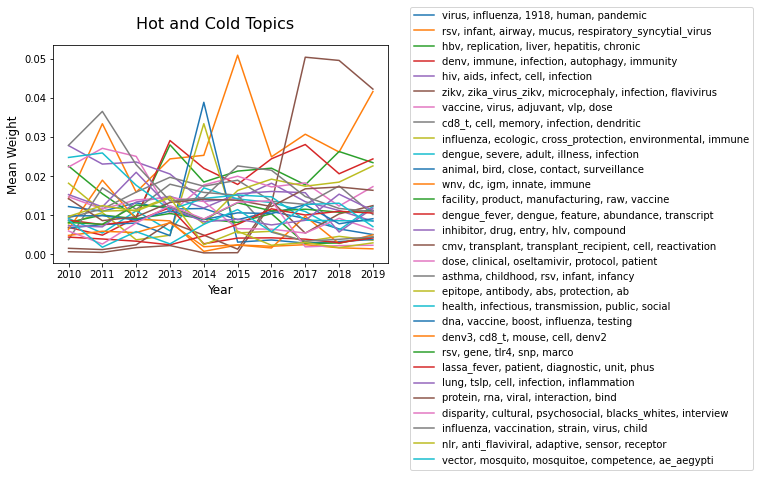

In [29]:
#Make Graphs
#leg = []
topic_results = {}
fig = plt.figure()
fig.suptitle('Hot and Cold Topics', fontsize=16)
ax = fig.add_subplot(111)

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    topic_results[i] = linear_fit.coef_[0][0]
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,i])
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#ax.yaxis.set_label_coords(-0.14,0.5)
plt.legend(leg,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()

In [30]:
class HandlerDashedLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines


In [31]:
# {column index, slope} - ex) 1: Topic 0 because Topic 0 is column 1 in the dataframe

topic_results

{1: -0.0007333877071754537,
 2: 0.0018040328831855957,
 3: 0.0006652807478100185,
 4: 0.002083392568331461,
 5: -0.0019087540488481778,
 6: 0.006034915593872668,
 7: -0.000969271062751525,
 8: 9.844125245000055e-05,
 9: -0.0006516540018516153,
 10: 0.0003096502765931134,
 11: -0.0007362954926482021,
 12: -0.0008586686532731894,
 13: -0.0007076877911044316,
 14: -0.000718662835553196,
 15: 0.0003068206386972448,
 16: 0.0011525546424196206,
 17: -0.0010063000075828386,
 18: -0.000996037426793539,
 19: 0.000877156136572735,
 20: -0.001829008033436158,
 21: -1.0647497964704385e-05,
 22: -0.000568400009807578,
 23: 0.0002763060104637601,
 24: 0.001026567138210735,
 25: -0.0005360135449038473,
 26: 0.0006798608920710908,
 27: -0.00035306865411332617,
 28: -0.002036517803449092,
 29: -0.0012703596450920982,
 30: 0.0006761273963069891}

In [32]:
def sort_dict(x):
    return sorted(x.items(), key=lambda l: l[1], reverse=True)

In [33]:
sort_slopes = sort_dict(topic_results)
top_slopes = [x[0] for x in sort_slopes[:5]]
bottom_slopes = [x[0] for x in sort_slopes[-5:]]

In [34]:
sort_slopes

[(6, 0.006034915593872668),
 (4, 0.002083392568331461),
 (2, 0.0018040328831855957),
 (16, 0.0011525546424196206),
 (24, 0.001026567138210735),
 (19, 0.000877156136572735),
 (26, 0.0006798608920710908),
 (30, 0.0006761273963069891),
 (3, 0.0006652807478100185),
 (10, 0.0003096502765931134),
 (15, 0.0003068206386972448),
 (23, 0.0002763060104637601),
 (8, 9.844125245000055e-05),
 (21, -1.0647497964704385e-05),
 (27, -0.00035306865411332617),
 (25, -0.0005360135449038473),
 (22, -0.000568400009807578),
 (9, -0.0006516540018516153),
 (13, -0.0007076877911044316),
 (14, -0.000718662835553196),
 (1, -0.0007333877071754537),
 (11, -0.0007362954926482021),
 (12, -0.0008586686532731894),
 (7, -0.000969271062751525),
 (18, -0.000996037426793539),
 (17, -0.0010063000075828386),
 (29, -0.0012703596450920982),
 (20, -0.001829008033436158),
 (5, -0.0019087540488481778),
 (28, -0.002036517803449092)]

In [35]:
top_slopes

[6, 4, 2, 16, 24]

In [36]:
bottom_slopes

[17, 29, 20, 5, 28]

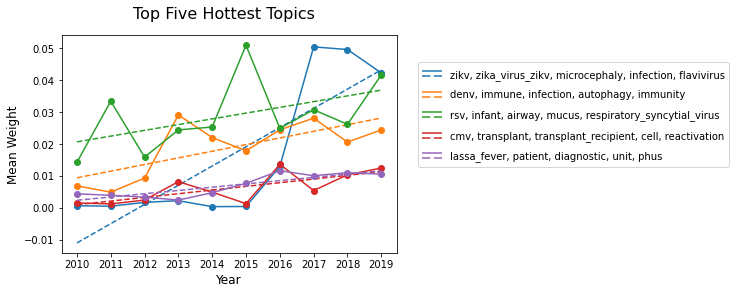

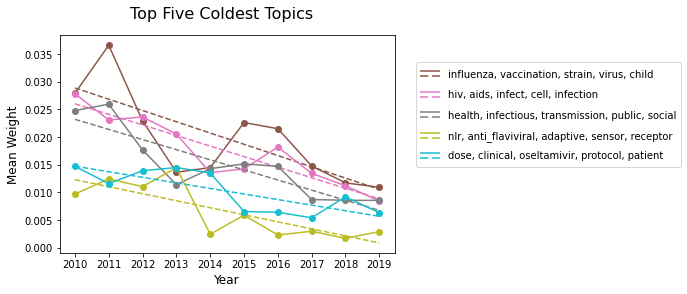

In [37]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]


line_return = []
fig = plt.figure()
fig.suptitle('Top Five Hottest Topics', fontsize=16)
ax = fig.add_subplot(111)
line = [[(0, 0)]]
i = 0
for n in top_slopes:
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o')
    line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
plt.legend(line_return, [leg[x-1] for x in top_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

#plt.legend([leg[x] for x in top_slopes],bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()


#Make Graphs
#leg = []

bottom_slopes.reverse()  # so the plot legend has the coldest listed first

line_return = []
fig = plt.figure()
fig.suptitle('Top Five Coldest Topics', fontsize=16)
ax = fig.add_subplot(111)
i = 0
for n in bottom_slopes:
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i+5])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color=color_list[i+5])
    line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i+5],color_list[i+5]]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
plt.legend(line_return, [leg[x-1] for x in bottom_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

#plt.legend([leg[x] for x in top_slopes],bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()


In [38]:
bottom_slopes

[28, 5, 20, 29, 17]

In [39]:
[leg[x-1] for x in bottom_slopes]

['influenza, vaccination, strain, virus, child',
 'hiv, aids, infect, cell, infection',
 'health, infectious, transmission, public, social',
 'nlr, anti_flaviviral, adaptive, sensor, receptor',
 'dose, clinical, oseltamivir, protocol, patient']

In [40]:
#Melt to get the data for graphing purposes 
#topic_df = topic_frame.melt(id_vars =['START_YEAR'], var_name = "Topic", value_name = "Weight")